### IEMS 394

#### Data Pipeline
Objective: Load and clean data, save as pickle.

In [36]:
%%time
import matplotlib.pyplot as plt
from shapely.geometry import shape, Point, Polygon
import pandas as pd
from tqdm import tqdm
import os, geojson, multiprocessing, datetime, time
import concurrent.futures
# %matplotlib tk

os.chdir('/Users/saifbhatti/Desktop/Northwestern/sy1920/s20/iems394/client-data/cleaned_data')

with open('us_counties_2010.json', encoding = "ISO-8859-1") as f:
    gj = geojson.load(f)
    
    
selected_states = ['TX','CA','MN']

CPU times: user 2.05 s, sys: 379 ms, total: 2.43 s
Wall time: 2.59 s


### Vision (end goals)

- Data Cleaning (python file) 
    - read in appropriate csv files that have been cleaned
    - convert to dataframe
    - pickle
- AMPL szn (python file)
    - unpickle
    - AMPLpy code that uses the dataframes as decision parameters
- Visualisation (ipynb)
    - either 

### Files

Vehicle Data:
- EV_Ranges.csv
- vehicle_ages.csv
- vehicles_available.csv
- trip_purpose_miles.csv
- HI_vehicles.csv
- HEV_model-sales.csv
- PEV_model-sales.csv
- Distance.csv



#### Import and Clean Vehicle Data

In [ ]:
df = pd.read_csv('HEV_model-sales.csv',skiprows=1,thousands=',')
df.drop('Total',axis=1,inplace=True)
df.drop(df.index[df.shape[0]-1],inplace=True)
df.set_index(df['Vehicle'],inplace=True)
df.drop('Vehicle',axis=1,inplace=True)
df = df.applymap(lambda x: x.replace('-','0'))
df = df.applymap(lambda x: x.replace(",", ""))
# df = df.applymap(lambda x: x=int(x))
cols=[i for i in df.columns if i not in ['Vehicle']]
for col in cols:
    df[col]=pd.to_numeric(df[col])
hybrid_df = df

In [ ]:
hybrid_df['total']= hybrid_df.sum(axis=1) #total sum per column
# hybrid_df['total'].plot(kind='bar',x='name',y='sales volume')
# hybrid_df

In [ ]:
df = pd.read_csv('PEV_model-sales.csv',skiprows=1,thousands=',')
df.drop('Total',axis=1,inplace=True)
df.drop(df.index[df.shape[0]-1],inplace=True)
df.set_index(df['Vehicle'],inplace=True)
df.drop('Vehicle',axis=1,inplace=True)
# df.replace(to_replace='-',value=';')
df = df.applymap(lambda x: x.replace('-','0'))
df = df.applymap(lambda x: x.replace(",", ""))
cols=[i for i in df.columns if i not in ['Type']]
for col in cols:
    df[col]=pd.to_numeric(df[col])
electric_df = df

In [ ]:
EV_ranges_df =  pd.read_csv('EV_ranges.csv')

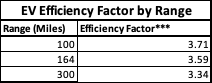

In [ ]:
df = pd.read_csv('electric_fuel_stations.csv')
electric_fuel_df = df
df.head()

In [ ]:
# df['point'] = df['Longitude'] + df['Latitude']
df['Points'] = list(zip(df['Longitude'], df['Latitude']))
# df.tail(20)
df.head()

In [ ]:
def geo_map(x):
    '''
    geo_map takes pandas Series object constructed in the format (longitude, latitude).
    Taking this as the point, a geo.json file is imported containing all US counties from the 2010 census as polygons.
    It computes whether the point is within a polygon, and returns a list of all matches. 
    If a point is not matched, it returns None.
    '''
    point = Point(x)
    for i in range(len(gj['features'])):
        polygon = shape(gj['features'][i]['geometry'])
        if polygon.contains(point):
            return gj['features'][i]['properties']['NAME']

In [ ]:
def geo_two(x):
    '''
    geo_map takes pandas Series object constructed in the format (longitude, latitude).
    Taking this as the point, a geo.json file is imported containing all US counties from the 2010 census as polygons.
    It computes whether the point is within a polygon, and returns a list of all matches. 
    If a point is not matched, it returns None.
    '''
    counties = []
    for i in tqdm(x):
        point = Point(x)
        for i in range(len(gj['features'])):
            polygon = shape(gj['features'][i]['geometry'])
            if polygon.contains(point):
                counties.append(gj['features'][i]['properties']['NAME'])

In [ ]:
counties = []
points_list = list(df['Points'])
# for i in tqdm(points_list):
#     counties.append(geo_map(i))

In [ ]:
# electric_fuel_df['County'] = counties

In [ ]:
# electric_fuel_df.to_csv('electric_fuel_stations.csv')

In [ ]:
# electric_fuel_df

In [ ]:
electric_df.to_pickle("./dummy.pkl")

### Convert data from zipcode to county.

In [ ]:
tx_ev_vehicle_registered = pd.read_csv('vehicle_reg/tx_ev_registrations_public.csv')
print(len(tx_ev_vehicle_registered['ZIP Code'].unique()))
print(len(tx_ev_vehicle_registered))
tx_ev_vehicle_registered.head()

In [ ]:
mn_ev_vehicle_registered = pd.read_csv('vehicle_reg/mn_ev_registrations_public.csv')
mn_ev_vehicle_registered.drop(['VIN Prefix','VIN Model Year'],inplace=True,axis=1)
print(len(mn_ev_vehicle_registered['ZIP Code'].unique()))
print(len(mn_ev_vehicle_registered))
mn_ev_vehicle_registered.head()

In [ ]:
result = pd.concat([mn_ev_vehicle_registered, tx_ev_vehicle_registered], axis=0)
print(len(result['ZIP Code'].unique()))
print(result.shape)
result.head()

In [ ]:
us_zips = pd.read_csv('uszips.csv')
print(us_zips.shape)
us_zips.head()

In [ ]:
# len(us_zips[(us_zips['zip'] > 70000) & (us_zips['zip'] < 90000)])

In [ ]:
us_zips.columns

In [ ]:
new = pd.merge(result, us_zips, how='inner', left_on='ZIP Code', right_on='zip')

In [ ]:
new['state_id'].unique()

In [ ]:
len(new[(new['state_id'] == 'TX') | (new['state_id'] == 'MN')])

In [ ]:
new.shape[0]

In [ ]:
new = new[(new['state_id'] == 'TX') | (new['state_id'] == 'MN')]
new['state_id'].unique()

In [ ]:
new.columns

In [ ]:
new.groupby('state_id').count()

In [ ]:
new.columns

In [ ]:
new.to_csv('ev_registration_county.csv')

In [ ]:
cali = pd.read_csv('california_car_data.csv')
cali['Fuel'].unique()

In [ ]:
cali.head()

Within the `IRS Individual Tax Income` dataset, the following columns are extracted:
- `STATE`: the relevant state the form was filed in.
- `zipcode`: the relevant zipcode the form was filed in.
- `NI`: Number of Returns.
- `A02650`: Total Income Amount.

Run `!curl https://www.irs.gov/pub/irs-soi/17zpallagi.csv -o irs.csv` to download.

In [ ]:
irs = pd.read_csv('irs.csv') #read in the csv
irs = irs[['STATE','zipcode','A02650','N1']] #only keep a few columns (detailed above)
irs = irs.rename(columns={'A02650': 'total_income_amt', 'N1': 'return_count'})
irs.columns

In [ ]:
irs['avg_income_amt'] = irs['total_income_amt'] / irs['return_count']

In [ ]:
ranked_irs = irs.groupby('STATE').sum()
ranked_irs.sort_values(by='avg_income_amt', ascending=False).head()

In [ ]:
irs = irs[irs['STATE'].isin(selected_states)] #keep only relevant states
irs.groupby('STATE').sum()

In [ ]:
irs.to_csv('income_levels_state.csv')

In [ ]:
irs_county = pd.merge(irs, us_zips, how='inner', left_on='zipcode', right_on='zip')

In [ ]:
irs_county.drop(['county_weights','county_fips_all','imprecise','military'],axis=1,inplace=True)

In [ ]:
irs_county.to_csv('irs_income_levels_county.csv')

In [ ]:
print(irs_county.columns) #irs_income_levels_county.csv
print(irs.columns) #income_levels_state.csv
print(new.columns) #ev_registration_county.csv
print(electric_fuel_df.columns) #electric_fuel_stations.csv

In [ ]:
e85 = pd.read_csv('e85_fuel_stations.csv')

In [ ]:
e85['Points'] = list(zip(e85['Longitude'], e85['Latitude']))
e85

In [ ]:
# counties = []
# points_list = list(e85['Points'])
# for i in tqdm(points_list): 
#     counties.append(geo_map(i))
# e85['County'] = counties
# e85.to_csv('e85_fuel_stations.csv')

In [ ]:
e85.groupby('County').count().sort_values(by='City', ascending=False).head(5)

In [ ]:
# e85[e85['County']=="Los Angeles"]
e85.groupby('State').count().sort_values(by='Fuel Type Code', ascending=False).head(10)

In [ ]:
centroids = pd.read_csv('county_centroids.csv')

In [ ]:
centroids['Latitude'] = centroids['Latitude'].apply(lambda x: x.strip('°'))
centroids['Longitude'] = centroids['Longitude'].apply(lambda x: x.strip('°'))
centroids['Longitude'] = centroids['Longitude'].apply(lambda x: x.replace('–','-'))
centroids['Latitude'] = centroids['Latitude'].apply(lambda x: x.replace('+',''))

In [ ]:
centroids['Points'] = list(zip(centroids['Longitude'], centroids['Latitude']))

In [ ]:
selected_centroids = centroids[centroids['State'].isin(selected_states)]

In [ ]:
selected_centroids

stuff to do today:
    
- focus on 394, clean up this file, solve the problem, make a new document
- then focus on renoster, create a list of tasks we have to do. pick 1 simple format and stick to it.

In [ ]:
def create_circles(x,rad):
    '''
    county_scanner takes pandas Series object constructed in the format (longitude, latitude).
    Taking a point (which is the fuelling station) and constructs a circle of radius 'rad'.
    This is stored to a geojson file.???
    '''
    point = Point(x)
    return point.buffer(rad)
    

In [ ]:
e85_points = e85['Points']
circles = []
for i in tqdm(e85_points):
    circles.append(create_circles(i,10000))

In [ ]:
print(circles[1].centroid)

In [ ]:
import numpy as np
import json
import geog
import shapely.geometry
# p = shapely.geometry.Point([-80.966548, 35.030458])
e85_points = e85['Points']
geo_df = pd.DataFrame()
geo_df['points'] = e85_points
geometry_string = []

for i,j in tqdm(list(enumerate(e85_points))):
    p = Point(j)
    n_points = 20
    d = 10 * 1000 # meters
    angles = np.linspace(0, 360, n_points)
    polygon = geog.propagate(p, angles, d)
#     print(json.dumps(shapely.geometry.mapping(shapely.geometry.Polygon(polygon))) + '\n')
#     geometry_list.append(json.dumps(shapely.geometry.mapping(shapely.geometry.Polygon(polygon))))
    geometry_string.append(shapely.geometry.Polygon(polygon))

geo_df['coordinates'] = geometry_string
geo_df['name'] = e85['County']
desc = []
for i in range(geo_df.shape[0]): desc.append('e85 station')
geo_df['description'] = desc

In [ ]:
type(geo_df)

In [ ]:
geometry_list[0]

In [ ]:
def data2geojson(df):
    features = []
    insert_features = lambda x: features.append(
            geojson.Feature(geometry=x['coordinates'],
                            properties=dict(name=x["name"],
                                            description=x["description"])))
    df.apply(insert_features, axis=1)
    with open('map1.geojson', 'w', encoding='utf8') as fp:
        geojson.dump(geojson.FeatureCollection(features), fp, sort_keys=True, ensure_ascii=False)
data2geojson(geo_df)


In [22]:
import fiona
from tqdm import tqdm
from shapely.geometry import shape

path1 = '/Users/saifbhatti/Downloads/cb_2018_us_county_500k/cb_2018_us_county_500k.shp' #US county shapefile
path2 = '/Users/saifbhatti/Downloads/mygeodata/map1-polygon.shp' #e85 stations

polygon1 = fiona.open(path1) #us counties
polygon8 = fiona.open(path2) #e85 stations

geom_p1 = [ shape(feat["geometry"]) for feat in polygon1 ] #us counties
geom_p8 = [ shape(feat["geometry"]) for feat in polygon8 ] #e85 stations

e85_viability_index = pd.DataFrame(columns = ['county','e85 station','area'])

for i, g1 in tqdm(enumerate(geom_p1)): #for each county
    for j, g8 in enumerate(geom_p8): #for each e85 station
        if g1.intersects(g8): #check if e85 station is within US county
#             print (i, j, ()
            df1 = pd.DataFrame([[i,j,(g1.intersection(g8).area/g1.area)*100]],columns = ['county','e85 station','area'])
            e85_viability_index = e85_viability_index.append(df1)
            

3233it [01:01, 52.69it/s]


In [35]:
# e85.groupby('State').count().sort_values(by='Fuel Type Code', ascending=False).head(10)

e85_viability_index.groupby(['county']).sum().sort_values(by='area',ascending=False).head(10)

,area
county,
2024,1882.370919
351,1100.540713
1335,820.974461
2013,708.481828
289,691.502526
1468,690.259506
1839,670.063939
3231,651.826340
3126,559.078751


In [9]:
for i in range(2):
    df2 = df2.append(df1)
print(df2)

   a  b
0  1  2
0  1  2
0  1  2
0  1  2
0  1  2
0  1  2
0  1  2
0  1  2
0  1  2
0  1  2
0  1  2
0  1  2
0  1  2
0  1  2


In [19]:
e85_viability_index = pd.DataFrame(columns = ['county','e85 station','area'])
for i in range(2):
#     df1 = 
    e85_viability_index = e85_viability_index.append(pd.DataFrame([[1,2,3]],columns = ['county','e85 station','area']))
e85_viability_index


,county,e85 station,area
0,1,2,3
0,1,2,3


In [ ]:
import folium

In [ ]:
m = folium.Map()
m.choropleth(world, data=world, key_on='feature.properties.name',
             columns=['name', 'pop_est'], fill_color='YlOrBr')
m

In [ ]:
def county_scanner(circles, x,y):
    
    point = Point(x,y)
    for i in circles:
        if i.contains(point):
            return i.centroid

In [ ]:
# selected_centre = list(selected_centroids['Points'])
# type(selected_centre[1])

# for i in selected_centre:
#     x = float(i[0])
#     y = float(i[1])
#     print(county_scanner(circles, x,y))

In [ ]:
from shapely import geometry

# create your two points
point_1 = geometry.Point(37.774929,-122.419418)
point_2 = geometry.Point(37.774929,-122.419418)

# create your circle buffer from one of the points
distance = 1000
circle_buffer = point_1.buffer(distance)

# and you can then check if the other point lies within
if point_2.within(circle_buffer):
    print('point 2 is within the distance buffer of point 1')
# or similarly
if circle_buffer.contains(point_2):
    print('circle buffer contains point 2')

# but a simpler method is to simply check the distance
if point_1.distance(point_2) < distance:
    print('point 1 is within the distance of point 2')

In [ ]:
import fiona
shape = fiona.open("/Users/saifbhatti/Downloads/c_03mr20/c_03mr20.shp")
print (shape.schema)


In [ ]:
import geopandas as gpd
shapefile = gpd.read_file("/Users/saifbhatti/Downloads/c_03mr20/c_03mr20.shp")
# print(shapefile)
shapefile = shapefile[shapefile['STATE'].isin(selected_states)]
print(len(shapefile['COUNTYNAME'].unique()))
shapefile.shape

In [ ]:
shapefile.drop_duplicates(subset ="COUNTYNAME", keep = False, inplace = True) 
shapefile.shape

In [ ]:
san_fran = Point(37.774929,-122.419418)

In [ ]:
if b.contains(san_fran):
    print('yes')
else:
    print('no :(')

In [ ]:
import pyproj as proj

# setup your projections
crs_wgs = proj.Proj(init='epsg:4326') # assuming you're using WGS84 geographic

# then cast your geographic coordinate pair to the projected system
x, y = proj.transform(crs_wgs,crs_wgs,-122.41,37.77)



In [ ]:
from shapely import geometry

# create your two points
point_1 = geometry.Point(37.774929,-122.419418)
point_2 = geometry.Point(37.774929,-122.419418)

# create your circle buffer from one of the points
distance = 1000
circle_buffer = point_1.buffer(distance)

# and you can then check if the other point lies within
if point_2.within(circle_buffer):
    print('point 2 is within the distance buffer of point 1')
# or similarly
if circle_buffer.contains(point_2):
    print('circle buffer contains point 2')

# but a simpler method is to simply check the distance
if point_1.distance(point_2) < distance:
    print('point 1 is within the distance of point 2')

In [ ]:
type(circle_buffer)